In [1]:
] activate .; instantiate;

Activating environment at `~/.julia/dev/LITS-Examples/Project.toml`


# Tutorial: Dynamic Lines

This tutorial will introduce an example of considering dynamic lines in `LITS`.
Note that this tutorial is for `LITS 0.3.0`. Future versions will have dedicated functions to find an equilibrium point using a Power Flow method without relying in a guess of the initial condition to run a non-linear solver.

This tutorial presents a simulation of a three-bus system, with an infinite bus (represented as a voltage source behind an impedance) at bus 1, and a one d- one q- machine on bus 2 and an inverter of 19 states, as a virtual synchronous machine at bus 3. The perturbation will be the trip of two of the three circuits (triplicating its resistance and impedance) of the line that connects bus 1 and bus 3. This case also consider a dynamic line model for connection between buses 2 and 3.

It is recommended to check `Tutorial 1: OMIB` first, since that includes more details and explanations on all definitions and functions.

## Step 1: Package Initialization

Loading packages may take some time:

In [2]:
using LITS
using PowerSystems
using Sundials
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


PowerSystems

## Step 2: Data creation

To start we will define the data structures for the network.

### Buses and Branches

In [3]:
nodes_case9 = [
    Bus(1, "Bus 1", "REF", 0, 1.02, (min = 0.94, max = 1.06), 138),
    Bus(2, "Bus 2", "PV", 0, 1.00, (min = 0.94, max = 1.06), 138),
    Bus(3, "Bus 3", "PQ", 0, 1.00, (min = 0.94, max = 1.06), 138),
]

branch_case9 = [
    Line(
        "Line1",
        true,
        0.0,
        0.0,
        Arc(from = nodes_case9[1], to = nodes_case9[3]),
        0.01,
        0.12,
        (from = 0.1, to = 0.1),
        100,
        1.04,
    ),
    Line(
        "Line2",
        true,
        0.0,
        0.0,
        Arc(from = nodes_case9[1], to = nodes_case9[2]),
        0.01,
        0.12,
        (from = 0.1, to = 0.1),
        100,
        1.04,
    ),
    Line(
        "Line3",
        true,
        0.0,
        0.0,
        Arc(from = nodes_case9[2], to = nodes_case9[3]),
        0.02,
        0.9,
        (from = 0.5, to = 0.5),
        100,
        1.04,
    ),
]

#Trip of Line 1. Triplicates its impedance
branch_case9_fault = [
    Line(
        "Line1",
        true,
        0.0,
        0.0,
        Arc(from = nodes_case9[1], to = nodes_case9[3]),
        0.03,
        0.36,
        (from = 0.03, to = 0.03),
        100,
        1.04,
    ),
    Line(
        "Line2",
        true,
        0.0,
        0.0,
        Arc(from = nodes_case9[1], to = nodes_case9[2]),
        0.01,
        0.12,
        (from = 0.1, to = 0.1),
        100,
        1.04,
    ),
    Line(
        "Line3",
        true,
        0.0,
        0.0,
        Arc(from = nodes_case9[2], to = nodes_case9[3]),
        0.02,
        0.9,
        (from = 0.5, to = 0.5),
        100,
        1.04,
    ),
]

3-element Array{Line,1}:
 Line("Line1", true, 0.0, 0.0, Arc(Bus(1, "Bus 1", PowerSystems.REF, 0.0, 1.02, (min = 0.94, max = 1.06), 138.0, Dict{String,Any}(), InfrastructureSystems.InfrastructureSystemsInternal(UUID("4fba84ff-a5f5-4513-a483-3269bfa76514"), nothing)), Bus(3, "Bus 3", PowerSystems.PQ, 0.0, 1.0, (min = 0.94, max = 1.06), 138.0, Dict{String,Any}(), InfrastructureSystems.InfrastructureSystemsInternal(UUID("a3cf033f-bda3-4642-8d99-068e1568001d"), nothing)), InfrastructureSystems.InfrastructureSystemsInternal(UUID("b18d4679-bb68-4be2-a8fb-442a27a39105"), nothing)), 0.03, 0.36, (from = 0.03, to = 0.03), 100.0, (min = -1.04, max = 1.04), Service[], Dict{String,Any}(), InfrastructureSystems.Forecasts(Dict{InfrastructureSystems.ForecastKey,InfrastructureSystems.ForecastInternal}(), nothing), InfrastructureSystems.InfrastructureSystemsInternal(UUID("35230f45-5d0a-4108-bc98-f0df237ab91f"), nothing))
 Line("Line2", true, 0.0, 0.0, Arc(Bus(1, "Bus 1", PowerSystems.REF, 0.0, 1.02, (min

### Injection devices

In [4]:
loads_case9 = [
    PowerLoad("Bus1", true, nodes_case9[1], PowerSystems.ConstantPower, 0.5, 0.1, 1.5, 0.8),
    PowerLoad("Bus2", true, nodes_case9[2], PowerSystems.ConstantPower, 1.0, 0.3, 1.5, 0.8),
    PowerLoad("Bus3", true, nodes_case9[3], PowerSystems.ConstantPower, 0.3, 0.1, 0.5, 0.3),
]

inf_gen_case9 = [Source(
    "InfBus", #name
    true, #availability
    nodes_case9[1],#bus
    1.00, #VR
    0.0, #VI
    0.000005,
)] #Xth

1-element Array{Source,1}:
 Source("InfBus", true, Bus(1, "Bus 1", PowerSystems.REF, 0.0, 1.02, (min = 0.94, max = 1.06), 138.0, Dict{String,Any}(), InfrastructureSystems.InfrastructureSystemsInternal(UUID("4fba84ff-a5f5-4513-a483-3269bfa76514"), nothing)), 1.0, 0.0, 5.0e-6, Service[], Dict{String,Any}(), InfrastructureSystems.InfrastructureSystemsInternal(UUID("2f981b29-0ae8-4071-9b72-324deccc94a9"), nothing))

### Dynamic injection devices

First we define our generator data:

In [5]:
######## Machine Data #########

### Case 2: 4th Order Model with AVR (3-bus case) ###
case9_machine = OneDOneQMachine(
    0.0, #R
    1.3125, #Xd
    1.2578, #Xq
    0.1813, #Xd_p
    0.25, #Xq_p
    5.89, #Td0_p
    0.6, #Tq0_p
    100.0,
)   #MVABase

######## Shaft Data #########

### Shafts for Gen ###
case9_shaft = SingleMass(
    3.01, #H (M = 6.02 -> H = M/2)
    0.0,
) #D

######## PSS Data #########
cases_no_pss = PSSFixed(0.0)

######## TG Data #########

### No TG for Cases 1, 2, 3, 4 ###
case9_no_tg = TGFixed(1.0) #eff

########  AVR Data #########
### AVRs for Case 2, 3, 4 and 5 ###
case9_avr = AVRTypeI(
    20.0, #Ka - Gain
    0.01, #Ke
    0.063, #Kf
    0.2, #Ta
    0.314, #Te
    0.35, #Tf
    0.001, #Tr
    5.0, #Vrmax
    -5.0, #Vrmin
    0.0039, #Ae - 1st ceiling coefficient
    1.555,
) #Be - 2nd ceiling coefficient

### Case 7 Generators ###
case9_gen = DynamicGenerator(
    1, #Number
    "Case9Gen",
    nodes_case9[2], #bus
    1.0, # ω_ref,
    1.0124, #V_ref
    0.6, #P_ref
    0.0, #Q_ref
    case9_machine, #machine
    case9_shaft, #shaft
    case9_avr, #avr
    case9_no_tg, #tg
    cases_no_pss, #pss
);

and for the inverter:

In [6]:
converter = AvgCnvFixedDC(
    138.0, #Rated Voltage
    100.0,
) #Rated MVA

dc_source = FixedDCSource(1500.0) #Not in the original data, guessed.

filt = LCLFilter(
    0.08, #Series inductance lf in pu
    0.003, #Series resitance rf in pu
    0.074, #Shunt capacitance cf in pu
    0.2, #Series reactance rg to grid connection (#Step up transformer or similar)
    0.01,
) #Series resistance lg to grid connection (#Step up transformer or similar)

pll = PLL(
    500.0, #ω_lp: Cut-off frequency for LowPass filter of PLL filter.
    0.084, #k_p: PLL proportional gain
    4.69,
) #k_i: PLL integral gain

virtual_H = VirtualInertia(
    2.0, #Ta:: VSM inertia constant
    400.0, #kd:: VSM damping coefficient
    20.0, #kω:: Frequency droop gain in pu
    2 * pi * 50.0,
) #ωb:: Rated angular frequency

Q_control = ReactivePowerDroop(
    0.2, #kq:: Reactive power droop gain in pu
    1000.0,
) #ωf:: Reactive power cut-off low pass filter frequency

outer_control = VirtualInertiaQdroop(virtual_H, Q_control)

vsc = CombinedVIwithVZ(
    0.59, #kpv:: Voltage controller proportional gain
    736.0, #kiv:: Voltage controller integral gain
    0.0, #kffv:: Binary variable enabling the voltage feed-forward in output of current controllers
    0.0, #rv:: Virtual resistance in pu
    0.2, #lv: Virtual inductance in pu
    1.27, #kpc:: Current controller proportional gain
    14.3, #kiv:: Current controller integral gain
    0.0, #kffi:: Binary variable enabling the current feed-forward in output of current controllers
    50.0, #ωad:: Active damping low pass filter cut-off frequency
    0.2,
) #kad:: Active damping gain

case9_inv = DynamicInverter(
    2, #number
    "DARCO", #name
    nodes_case9[3], #bus location
    1.0, #ω_ref
    0.8, #V_ref
    0.5, #P_ref
    -0.3, #Q_ref
    100.0, #MVABase
    converter, #Converter
    outer_control, #OuterControl
    vsc, #Voltage Source Controller
    dc_source, #DC Source
    pll, #Frequency Estimator
    filt, #Output Filter
); 

### Defining the Dynamic System

In [7]:
#Create the system
sys = System(
      100.0, #Base MVA
      frequency = 50.0, #Nominal frequency in Hz
)

#Add the buses to the system
for bus in nodes_case9
    add_component!(sys, bus)
end

#Add the branches to the system
for br in branch_case9
    add_component!(sys, br)
end

make_dynamic_branch!(branch_case9[3], sys)

#Add the loads to the system
for load in loads_case9
    add_component!(sys, load)
end

#Add the sources (infinite gens) to the system
for source in inf_gen_case9
    add_component!(sys, source)
end

#Add the inverter
add_component!(sys, case9_inv)

#Add the generator
add_component!(sys, case9_gen)

┌ Warning: Data for line rating is 80.62251713919056 times larger than the base MVA for the system
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/juAqn/src/utils/IO/branchdata_checks.jl:103
┌ Warning: struct DynamicLine does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/wvWoQ/src/validation.jl:42
┌ Warning: struct DynamicInverter does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/wvWoQ/src/validation.jl:42
┌ Warning: struct DynamicGenerator does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/wvWoQ/src/validation.jl:42


## Step 3: Build the simulation and initializing the problem

First, we construct the perturbation, by properly computing the new Ybus:

In [8]:
#Obtain perturbed Ybus
sys2 = System(
      100.0, #Base MVA
      frequency = 50.0, #Nominal frequency in Hz
)

#Add the buses to the system
for bus in nodes_case9
    add_component!(sys2, bus)
end

#Add the fault branches to the system
for br in branch_case9_fault
    add_component!(sys2, br)
end

#make line 3 dynamic
make_dynamic_branch!(branch_case9_fault[3], sys2)

#Compute the Ybus
Ybus_fault = Ybus(sys2)[:,:]

#Construct the perturbation
perturbation_Ybus = ThreePhaseFault(
    1.0, #change will occur at t = 1.0s
    Ybus_fault, #new Ybus
);

┌ Warning: Data for line rating is 80.62251713919056 times larger than the base MVA for the system
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/juAqn/src/utils/IO/branchdata_checks.jl:103
┌ Warning: struct DynamicLine does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/wvWoQ/src/validation.jl:42


Now, we check the indexing:

In [9]:
#Time span of our simulation
tspan = (0.0, 30.0)

#Define Simulation
sim = Simulation(
    sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
    initialize_simulation = false #keyword argument to not find initial conditions.
)

Simulation()


In [10]:
ext = get_ext(sim.system) #Obtain ext information of the system
ext["global_index"] #Showcase the global indexing of z

Dict{String,Dict{Symbol,Int64}} with 5 entries:
  "V_3"      => Dict(:R=>3,:I=>6)
  "Case9Gen" => Dict(:Vf=>30,:Vr2=>32,:ed_p=>27,:ω=>29,:δ=>28,:eq_p=>26,:Vm=>33…
  "V_2"      => Dict(:R=>2,:I=>5)
  "DARCO"    => Dict(:iq_o=>25,:δθ_vsm=>8,:id_o=>24,:ϕ_q=>15,:qm=>9,:δθ_pll=>19…
  "Line3"    => Dict(:Il_I=>35,:Il_R=>34)

This is a clear example on which a flat start is not enough to properly initialize the system, so we provide a guess:

In [11]:
x0_guess = [1.00, #V1_R
          1.00, #V2_R
          1.00, #V3_R
          0.0, #V1_I
         -0.01, #V2_I
         -0.01, #V3_I
         0.0, #δω_vsm
          0.2, #δθ_vsm
          0.025, #qm
          0.0015, #ξ_d
          -0.07, #ξ_q
          0.05, #γ_d
        -0.001, #γ_q
         0.95, #ϕ_d
         -0.10, #ϕ_q
         1.004, #vpll_d
         0.0, #vpll_q
         0.0, #ε_pll
         0.1, #δθ_pll
         0.5, #id_cv
         0.0, #iq_cv
         0.95, #vod
         -0.1, #voq
         0.49, #iod
        -0.1, #ioq
          1.0, #eq_p
          0.47, #ed_p
          0.6, #δ
          1.0, #ω
          2.1, #Vf
          0.28, #Vr1
          -0.39, #Vr2,
          1.0, #Vm
          0.5, #IL1_R
          0.5] #IL1_I

sim = Simulation(
    sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
    initial_guess = x0_guess #initial guess.
)

┌ Info: Initializing Simulation States
└ @ LITS /Users/rhenriquez/.julia/packages/LITS/uFVsj/src/base/simulation.jl:27


Simulation()


## Step 4: Run the simulation

In [12]:
run_simulation!(sim, #simulation structure
                IDA()) #Sundials DAE Solver

## Step 5: Explore the solution

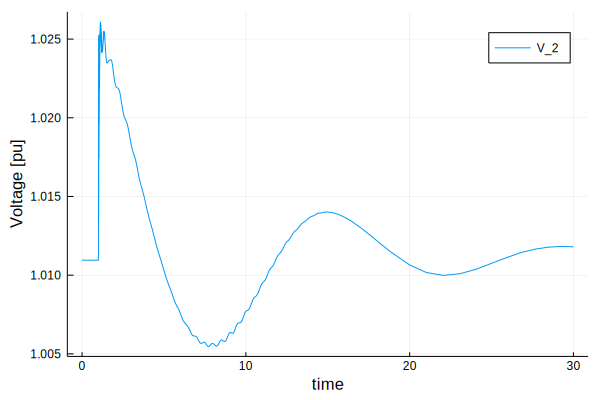

In [13]:
volt = get_voltagemag_series(sim, 2)
plot(volt, xlabel="time", ylabel="Voltage [pu]", label="V_2")

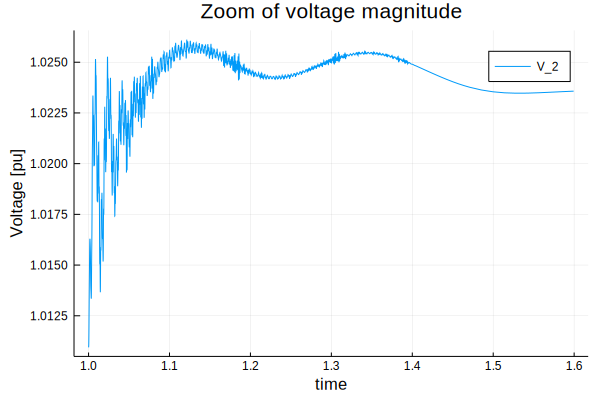

In [14]:
zoom = [(volt[1][ix], volt[2][ix]) for (ix, s) in enumerate(volt[1]) if (s > 0.90 && s < 1.6)]
plot(zoom, xlabel="time", ylabel="Voltage [pu]", title="Zoom of voltage magnitude", label="V_2")